# Mapping migration

Introduction to vector data operations

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [1]:
%store -r eco_gdf gbif_gdf

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out the <a
href="https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins"><code>geopandas</code>
documentation on spatial joins</a> to help you figure this one out. You
can also ask your favorite LLM (Large-Language Model, like ChatGPT)</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Perform a spatial join</div></div><div class="callout-body-container callout-body"><p>Identify the correct values for the <code>how=</code> and
<code>predicate=</code> parameters of the spatial join.</p></div></div>

In [2]:
gbif_eco_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)

    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        # an inner join here should remove ecoregions that have no Veery sightings, 
        # and any Veery sighting that aren't in any ecoregions.
        predicate='contains')

    # Select only required columns
    [['index_right', 'OBJECTID', 'month']]
    # In this case, the index is the ecoregion number
    .rename(columns={'OBJECTID': 'ecoregion',
                     'index_right': 'observation_id'})
)
gbif_eco_gdf

,observation_id,ecoregion,month
12,43461,13.0,5
12,73550,13.0,5
12,141749,13.0,6
12,72000,13.0,7
12,123537,13.0,6
...,...,...,...
839,123004,845.0,9
839,60931,845.0,10
839,87041,845.0,10
839,28267,845.0,9


### Count the observations in each ecoregion each month

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Group observations by ecoregion</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>columns_to_group_by</code> with a list of columns.
Keep in mind that you will end up with one row for each group – you want
to count the observations in each ecoregion by month.</li>
<li>Select only month/ecosystem combinations that have more than one
occurrence recorded, since a single occurrence could be an error.</li>
<li>Use the <code>.groupby()</code> and <code>.mean()</code> methods to
compute the mean occurrences by ecoregion and by month.</li>
<li>Run the code – it will normalize the number of occurrences by month
and ecoretion.</li>
</ol></div></div>

In [3]:
occurrence_df = (
    gbif_eco_gdf
    # For each ecoregion, for each month...
    .groupby(['ecoregion', 'month'])
    # ...count the number of occurrences
    .agg(occurrences=('observation_id', 'count'))
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences > 1]


# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ecoregion')
    .mean()
)
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)

# Call each variable to check that everything worked
# (run the cell twice, commenting out a different variable each time)
#mean_occurrences_by_ecoregion
#mean_occurrences_by_month

### Normalize the observations

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Normalize</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Divide occurrences by the mean occurrences by month AND the mean
occurrences by ecoregion</li>
</ol></div></div>

In [4]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df
    # Divide by ecoregion and month. This is minimizing effects of seasonality 
    # (cold, no one going out) or population (no one taking obs) bias
    / mean_occurrences_by_ecoregion
    / mean_occurrences_by_month
)
occurrence_df

occurrences  norm_occurrences
ecoregion month                               
13.0      5                2          0.000816
          6                2          0.000918
          7                2          0.001760
17.0      4                2          0.000010
          5             3023          0.001701
...                      ...               ...
839.0     7              297          0.002202
          8               40          0.001006
          9               11          0.000171
845.0     9               28          0.005575
          10               9          0.014447

[309 rows x 2 columns]

<Axes: xlabel='month', ylabel='occurrences'>

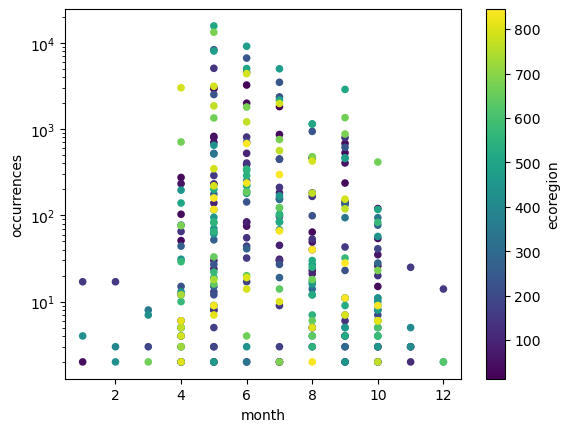

In [ ]:
# Quick Plot to make sure things look good

# occurrence_df.reset_index().plot.scatter(
#     x = 'month', y = 'norm_occurrences'
# )

occurrence_df.reset_index().plot.scatter(
    x = 'month', y = 'occurrences', c = 'ecoregion',
    logy = True
)

# These plots give me a quick glance at the data. 
# Not sure I fully understand how to read them or make something similar with different data, but we'll get there.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="f13606e9" class="cell" data-execution_count="9">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store occurrence_df</span></code></pre></div>
</div></div></div>

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [5]:
%store occurrence_df

Stored 'occurrence_df' (DataFrame)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!